--- Training Standard_PINN ---
Compiling model...
Building feed-forward neural network...
'build' took 0.085738 s



/tmp/ipython-input-13-718025952.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  h0 = float(x0_val * vy0_val - y0_val * vx0_val)


'compile' took 1.020075 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [4.86e+05, 3.33e+07, 8.82e+01, 7.32e+01]    [4.86e+05, 3.33e+07, 8.82e+01, 7.32e+01]    []  
2000      [3.22e-01, 4.16e+00, 3.96e+01, 6.78e+02]    [3.22e-01, 4.16e+00, 3.96e+01, 6.78e+02]    []  
4000      [8.36e+00, 2.29e+01, 4.19e+01, 7.97e+01]    [8.36e+00, 2.29e+01, 4.19e+01, 7.97e+01]    []  
6000      [1.19e+01, 1.31e+01, 3.79e+01, 2.10e+01]    [1.19e+01, 1.31e+01, 3.79e+01, 2.10e+01]    []  
8000      [5.09e+00, 4.25e+00, 3.09e+01, 1.39e+01]    [5.09e+00, 4.25e+00, 3.09e+01, 1.39e+01]    []  
10000     [2.06e+00, 2.13e+00, 2.54e+01, 6.19e+00]    [2.06e+00, 2.13e+00, 2.54e+01, 6.19e+00]    []  
12000     [7.73e-01, 1.35e+00, 1.87e+01, 5.27e+00]    [7.73e-01, 1.35e+00, 1.87e+01, 5.27e+00]    []  
14000     [3.04e-01, 8.70e-01, 6.38e+00, 4.09e+00]    [3.04e-01, 8.70e-01, 6.38e+00, 4.09e+00]    []  
16000     [1.27e-01,

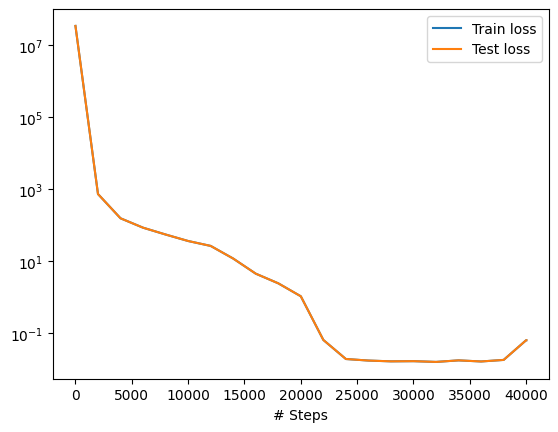

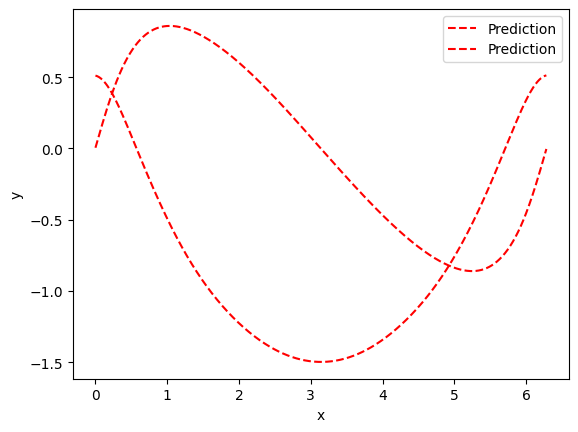

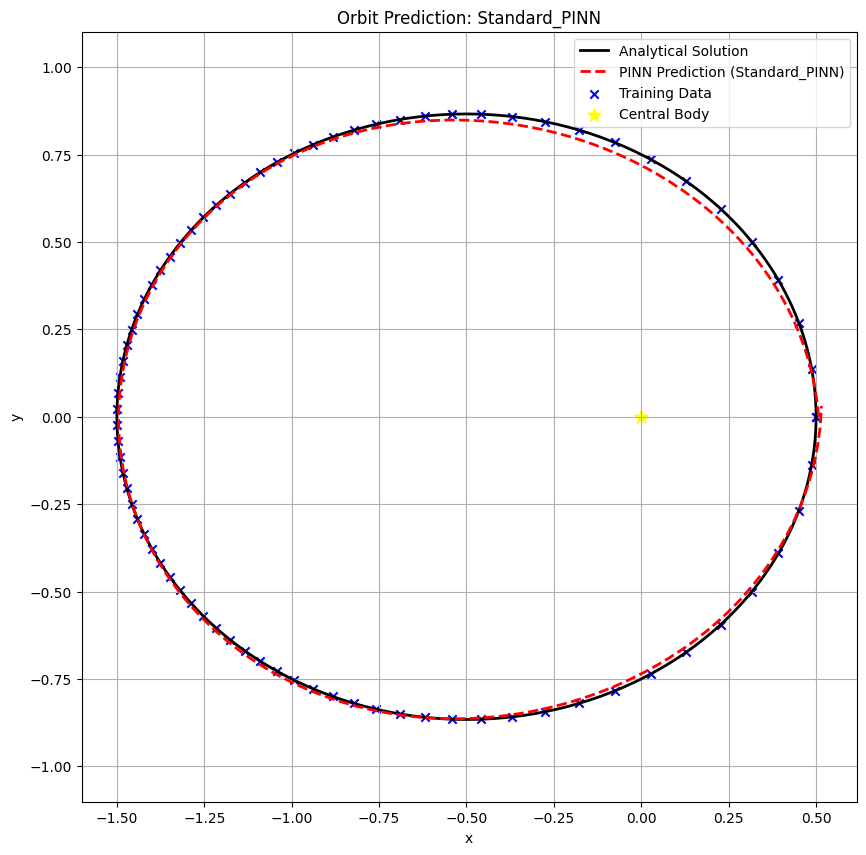

--- Training PINN_with_AngMom ---
Compiling model...
Building feed-forward neural network...
'build' took 0.135276 s

'compile' took 1.259138 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [4.86e+05, 3.33e+07, 7.40e+00, 8.82e+01, 7.32e+01]    [4.86e+05, 3.33e+07, 7.40e+00, 8.82e+01, 7.32e+01]    []  
2000      [3.23e-01, 4.16e+00, 6.53e+00, 3.97e+01, 6.77e+02]    [3.23e-01, 4.16e+00, 6.53e+00, 3.97e+01, 6.77e+02]    []  
4000      [8.36e+00, 2.28e+01, 5.98e+00, 4.23e+01, 7.95e+01]    [8.36e+00, 2.28e+01, 5.98e+00, 4.23e+01, 7.95e+01]    []  
6000      [1.18e+01, 1.30e+01, 5.74e+00, 3.81e+01, 2.07e+01]    [1.18e+01, 1.30e+01, 5.74e+00, 3.81e+01, 2.07e+01]    []  
8000      [4.99e+00, 4.23e+00, 5.12e+00, 3.09e+01, 1.34e+01]    [4.99e+00, 4.23e+00, 5.12e+00, 3.09e+01, 1.34e+01]    []  
10000     [1.87e+00, 2.09e+00, 3.55e+00, 2.49e+01, 5.71e+00]    [1.87e+00, 2.09e+00, 3.55e+

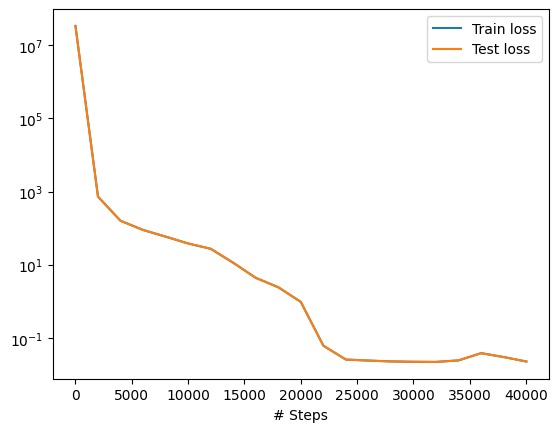

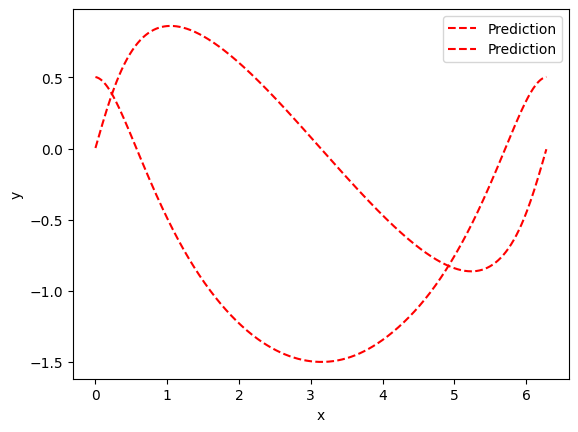

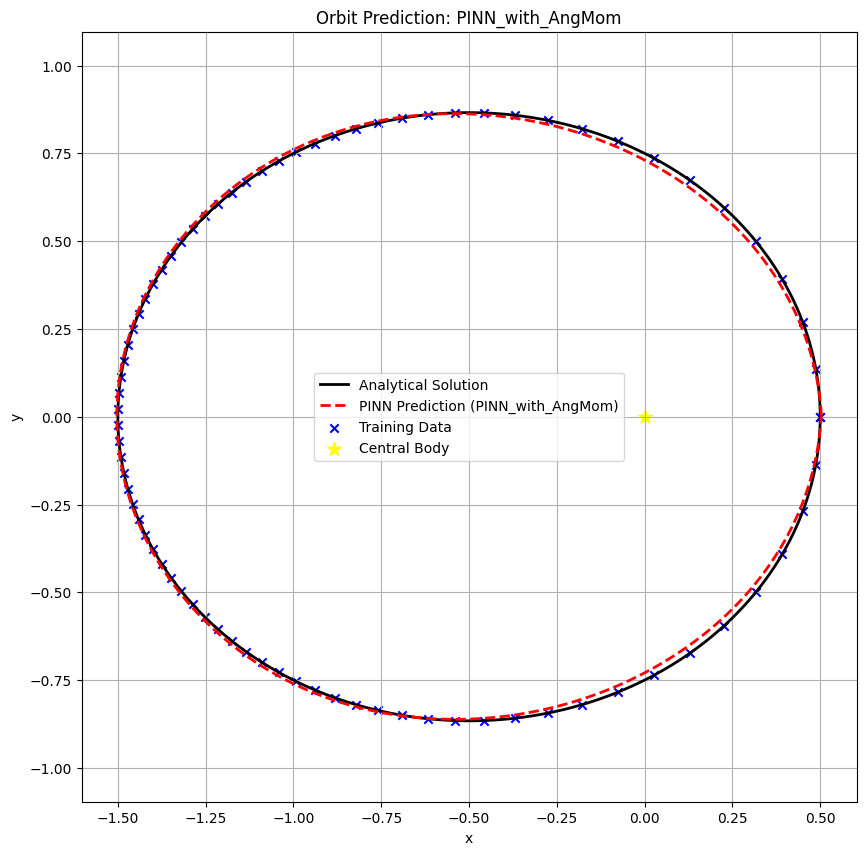

--- Training PINN_with_AngMom_IC ---
Compiling model...
Building feed-forward neural network...
'build' took 0.091463 s



KeyError: <module 'torch' from '/usr/local/lib/python3.11/dist-packages/torch/__init__.py'>

In [13]:
# Install deepxde if you haven't already
# !pip install deepxde

import numpy as np
import torch
import matplotlib.pyplot as plt

import os
os.environ['DDE_BACKEND'] = 'pytorch'

import deepxde as dde

# --- 1. Problem Setup and Analytical Data Generation ---

MU = 1.0
a = 1.0
e = 0.5
T = 2 * np.pi * np.sqrt(a**3 / MU)

def solve_kepler(M, e, tol=1e-9):
    E = M
    for _ in range(100):
        f = E - e * np.sin(E) - M
        f_prime = 1 - e * np.cos(E)
        E_new = E - f / f_prime
        if np.abs(E_new - E).all() < tol:
            return E_new
        E = E_new
    return E

def get_analytical_solution(t, a, e, mu):
    M = np.sqrt(mu / a**3) * t
    E = solve_kepler(M, e)
    x_orb = a * (np.cos(E) - e)
    y_orb = a * np.sqrt(1 - e**2) * np.sin(E)
    edot = np.sqrt(mu / a**3) / (1 - e * np.cos(E))
    vx_orb = -a * np.sin(E) * edot
    vy_orb = a * np.sqrt(1 - e**2) * np.cos(E) * edot
    return x_orb, y_orb, vx_orb, vy_orb

t_start, t_end = 0, T
geom = dde.geometry.TimeDomain(t_start, t_end)

n_data = 80
t_data = np.linspace(t_start, t_end, n_data).reshape(-1, 1)
x_true, y_true, vx_true, vy_true = get_analytical_solution(t_data, a, e, MU)
observe_x = dde.PointSetBC(t_data, x_true, component=0)
observe_y = dde.PointSetBC(t_data, y_true, component=1)
training_data = np.hstack((x_true, y_true))

# --- 2. Define the Physics and Loss Functions ---

# We now define each physical law as a separate function.
# This makes combining them for different models much cleaner.

def pde_system(t, u):
    x, y = u[:, 0:1], u[:, 1:2]
    ax = dde.grad.hessian(u, t, component=0, i=0, j=0)
    ay = dde.grad.hessian(u, t, component=1, i=0, j=0)
    r_sq = x**2 + y**2
    r = (r_sq + 1e-8)**0.5
    res_x = ax + MU * x / (r**3)
    res_y = ay + MU * y / (r**3)
    return [res_x, res_y]

# Initial angular momentum h0, calculated from initial conditions
x0_val, y0_val, vx0_val, vy0_val = get_analytical_solution(np.array([t_start]), a, e, MU)
h0 = float(x0_val * vy0_val - y0_val * vx0_val)

def angular_momentum_residual(t, u):
    x, y = u[:, 0:1], u[:, 1:2]
    vx = dde.grad.jacobian(u, t, i=0, j=0)
    vy = dde.grad.jacobian(u, t, i=1, j=0)
    h = x * vy - y * vx
    return h - h0


# --- 3. Model Definitions and Training ---

# Initial conditions from the analytical solution at t=0
ic_pos_x = dde.IC(geom, lambda t: torch.tensor(x0_val, dtype=dde.config.real(torch)), lambda _, on_initial: on_initial, component=0)
ic_pos_y = dde.IC(geom, lambda t: torch.tensor(y0_val, dtype=dde.config.real(torch)), lambda _, on_initial: on_initial, component=1)
ic_vel_x = dde.OperatorBC(geom, lambda t, u, _: dde.grad.jacobian(u, t, i=0, j=0) - vx0_val, lambda _, on_initial: on_initial)
ic_vel_y = dde.OperatorBC(geom, lambda t, u, _: dde.grad.jacobian(u, t, i=1, j=0) - vy0_val, lambda _, on_initial: on_initial)

# --- Model 1: Standard PINN (PDE + Data) ---
net1 = dde.nn.FNN([1] + [64] * 4 + [2], "tanh", "Glorot normal")
data1 = dde.data.PDE(geom, pde_system, [observe_x, observe_y], num_domain=500, num_boundary=2)
model1 = dde.Model(data1, net1)

# --- Model 2: PINN with Angular Momentum (PDE + Data + Ang. Mom.) ---
net2 = dde.nn.FNN([1] + [64] * 4 + [2], "tanh", "Glorot normal")
# We combine the pde_system (which has 2 outputs) with the new angular momentum residual (1 output)
# The PDE function passed to dde.data.PDE must return all residuals.
def combined_physics_model2(t, u):
    pde_res = pde_system(t, u)
    ang_mom_res = angular_momentum_residual(t, u)
    return pde_res + [ang_mom_res]

data2 = dde.data.PDE(geom, combined_physics_model2, [observe_x, observe_y], num_domain=500, num_boundary=2)
model2 = dde.Model(data2, net2)

# --- Model 3: PINN with Ang. Mom. and Initial Conditions ---
net3 = dde.nn.FNN([1] + [64] * 4 + [2], "tanh", "Glorot normal")
# The physics is the same as model 2, we just add more boundary/initial conditions
data3 = dde.data.PDE(geom, combined_physics_model2, [observe_x, observe_y, ic_pos_x, ic_pos_y, ic_vel_x, ic_vel_y], num_domain=500, num_boundary=2)
model3 = dde.Model(data3, net3)

# --- Training and Evaluation ---
def train_and_evaluate_model(model, model_name):
    print(f"--- Training {model_name} ---")
    if not os.path.exists(model_name):
        os.makedirs(model_name)

    # We can set weights for the different loss terms.
    # The order is: [PDE_x, PDE_y, (Ang_Mom), BC1, BC2, ...]
    # For model 2, the order is [PDE_x, PDE_y, Ang_Mom, Data_x, Data_y]
    # Let's give the angular momentum constraint a strong weight.
    loss_weights = [1, 1, 1, 10, 10] # Default for model 1 would be [1,1,10,10]
    if "AngMom" in model_name:
        if "IC" in model_name:
             # Model 3: [pde_x, pde_y, ang_mom, data_x, data_y, ic_x, ic_y, ic_vx, ic_vy]
             loss_weights = [1, 1, 10, 100, 100, 100, 100, 100, 100]
        else:
            # Model 2: [pde_x, pde_y, ang_mom, data_x, data_y]
            loss_weights = [1, 1, 10, 100, 100]
    else:
        # Model 1: [pde_x, pde_y, data_x, data_y]
        loss_weights = [1, 1, 100, 100]


    model.compile("adam", lr=1e-3, loss_weights=loss_weights)
    losshistory, train_state = model.train(iterations=40000, display_every=2000)

    print("--- Refining with L-BFGS ---")
    model.compile("L-BFGS", loss_weights=loss_weights)
    losshistory, train_state = model.train()

    dde.saveplot(losshistory, train_state, issave=True, isplot=True, output_dir=model_name)

    t_pred = np.linspace(t_start, t_end, 500).reshape(-1, 1)
    y_pred = model.predict(t_pred)
    x_true_fine, y_true_fine, _, _ = get_analytical_solution(t_pred, a, e, MU)

    plt.figure(figsize=(10, 10))
    plt.plot(x_true_fine, y_true_fine, "k-", label="Analytical Solution", linewidth=2)
    plt.plot(y_pred[:, 0], y_pred[:, 1], "r--", label=f"PINN Prediction ({model_name})", linewidth=2)
    plt.scatter(training_data[:, 0], training_data[:, 1], c='blue', marker='x', label="Training Data")
    plt.scatter([0], [0], s=100, c='yellow', marker='*', label="Central Body")
    plt.title(f"Orbit Prediction: {model_name}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.axis('equal')
    plt.grid(True)
    plt.savefig(f"{model_name}_orbit.png")
    plt.show()

    return y_pred

# Train models and store predictions
pred1 = train_and_evaluate_model(model1, "Standard_PINN")
pred2 = train_and_evaluate_model(model2, "PINN_with_AngMom")
pred3 = train_and_evaluate_model(model3, "PINN_with_AngMom_IC")

# --- Final Comparison Plot ---
t_plot = np.linspace(t_start, t_end, 500)
x_true_plot, y_true_plot, _, _ = get_analytical_solution(t_plot, a, e, MU)

plt.figure(figsize=(12, 12))
plt.plot(x_true_plot, y_true_plot, 'k-', label='Analytical Solution', linewidth=3, alpha=0.8)
plt.scatter(training_data[:, 0], training_data[:, 1], c='blue', marker='x', s=50, label="Training Data Points")
plt.plot(pred1[:, 0], pred1[:, 1], '--', label='Model 1: Standard PINN', linewidth=2)
plt.plot(pred2[:, 0], pred2[:, 1], '-.', label='Model 2: + Angular Momentum', linewidth=2)
plt.plot(pred3[:, 0], pred3[:, 1], ':', label='Model 3: + Ang. Mom. & ICs', linewidth=2, color='green')
plt.scatter([0], [0], s=150, c='orange', marker='o', edgecolors='black', label="Central Body")
plt.title("Comparison of PINN Models for Kepler's Problem")
plt.xlabel("x-position")
plt.ylabel("y-position")
plt.legend(loc='upper right')
plt.axis('equal')
plt.grid(True)
plt.savefig("final_comparison_orbit.png")
plt.show()